step25: 計算グラフの可視化(1)

25.1-4 Dot言語の基本

digraph g{
    1[label="x", color=orange, style=filled]
    2[label="y", color=orange, style=filled]
    3[label="Exp", color=lightblue, style=filled, shape=box]
    1 -> 3
    3 -> 2
}

step26: 計算グラフの可視化（２）

26.1-2 計算グラフからDot言語への変換

In [2]:
# 変数をDOT言語に変換
def _dot_var(v, verbose=False): # v: Variableインスタンス
    dot_var = '{} [label="{}", color=orange, style=filled]\n' # dot言語のフォーマット（{}部分はformat()の引数で置き換える）

    # Variableインスタンスに名前がなければ空白、あれば名前をnameに返す
    name = '' if v.name is None else v.name
    if verbose and v.data is not None: # Variableインスタンスの形状と型を出力する設定がオンかつそのインスタンスが実際データを保持する場合
        if v.name is not None: # Variableインスタンスに名前があれば
            name += ': ' # 文字列追加
        name += str(v.shape) + ' ' + str(v.dtype) # 形状と型の文字列追加

    return dot_var.format(id(v), name) # VariableインスタンスのオブジェクトIDと編集したnameをフォーマットに代入して返す

In [3]:
# 関数をDOT言語に変換＋入力と出力、関数ノードを矢印で結ぶ
def _dot_func(f, ferbose=False): # f: 関数インスタンス
    dot_func = '{} [label="{}", color=lightblue, style=filled, shape=box]\n' # dot言語のフォーマット（{}部分はformat()の引数で置き換える）
    txt = dot_func.format(id(f), f.__class__.__name__) # 関数インスタンスのオブジェクトIDと関数のクラス名をフォーマットに代入しtxtに返す

    dot_edge = '{} -> {}\n' # ノードを矢印で結ぶフォーマット
    for x in f.inputs: # 関数の入力
        txt += dot_edge.format(id(x), id(f)) # 入力→関数をdot_edgeフォーマットに代入してtxtに追加
    for y in f.outputs: # 関数の出力
        txt += dot_edge.format(id(f), id(y())) # 関数→出力をdot_edgeフォーマットに代入してtxtに追加
    return txt # 関数のノード化＋入出力と関数を矢印で結ぶ文字列が返される


In [4]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable

x = Variable(np.random.randn(2, 3))
x.name = 'x'
print(_dot_var(x))
print(_dot_var(x, verbose=True))

x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
y = x0 + x1
txt = _dot_func(y.creator)
print(txt)

2085179831936 [label="x", color=orange, style=filled]

2085179831936 [label="x: (2, 3) float64", color=orange, style=filled]

2084941316560 [label="Add", color=lightblue, style=filled, shape=box]
2085180459536 -> 2084941316560
2084941317712 -> 2084941316560
2084941316560 -> 2084941195952



In [5]:
def get_dot_graph(output, verbose=True):
    txt = ''
    funcs = []
    seen_set = set()

    # 初見の関数インスタンスだけfuncsリストに追加する関数（複数の出力を持つ関数が複数回funcsリストに入れないため）
    def add_func(f):
        if f not in seen_set:
            funcs.append(f)
            # funcs.sort(key = lambda x: x.generation) #  逆伝播みたいに出力側から順番に辿る必要はない（繋がりがわかりさえすればいい）
            seen_set.add(f)

    add_func(output.creator) # 最初(一番出力側)の関数だけ手動でfuncsリストに代入（それ以降の関数はループ内のadd_funcsで自動的にリストに追加される）
    txt += _dot_var(output, verbose) # 最初(一番出力側)の出力だけ手動でDOT言語変換するための関数を呼ぶ（それ以降はループ内）

    while funcs:
        func = funcs.pop()
        txt += _dot_func(func) # リストから得た関数をDOT言語に変換しtxtに追加＋矢印設定もtxtに追加
        for x in func.inputs:
            txt += _dot_var(x, verbose) # 関数の入力もDOT言語に変換しtxtに追加

            if x.creator is not None:
                add_func(x.creator) # ここで同じ関数が複数回呼ばれる場合があるからそれをadd_funcで弾いて一回だけリストに入れる
    return 'digraph g {\n' + txt + '}'

In [6]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable

x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
y = x0 + x1

x0.name = 'x0'
x1.name = 'x1'
y.name = 'y'

txt = get_dot_graph(y)
print(txt)

digraph g {
2084941201184 [label="y: () float64", color=orange, style=filled]
2085180472640 [label="Add", color=lightblue, style=filled, shape=box]
2085180349312 -> 2085180472640
2085180470240 -> 2085180472640
2085180472640 -> 2084941201184
2085180349312 [label="x0: () float64", color=orange, style=filled]
2085180470240 [label="x1: () float64", color=orange, style=filled]
}


26.3 画像化までを含めた変換（ターミナルのdotコマンド実行を含めた関数の実装）

In [7]:
import os
import subprocess

def plot_dot_graph(output, verbose=True, to_file='graph.png'):
    dot_graph = get_dot_graph(output, verbose)

    # 1.dotデータをファイルに保存
    #ホームディレクトリパスと.dezeroディレクトリ（そのディレクトリがあると仮定された）パスを結合して、.dezeroのパス（単に文字列）を生成
    tmp_dir = os.path.join(os.path.expanduser('~'), '.dezero') #C:\Users\jiwon\.dezero (一時的な保存先)
    # tmp_dirが存在しない場合、新しくディレクトリを作成
    if not os.path.exists(tmp_dir):
        os.mkdir(tmp_dir) # C:\Users\jiwon\.dezeroに新しくディレクトリ作成
    graph_path = os.path.join(tmp_dir, 'tmp_graph.dot') # dezeroディレクトリ内ににdotファイルを作成するためにパス(C:\Users\jiwon\.dezero\tmp_graph.dot)を生成

    with open(graph_path, 'w') as f: # C:\Users\jiwon\.dezero\tmp_graph.dot上にファイルを作成し
        f.write(dot_graph) # dot_graphの内容をそのファイルに書き込む

    # 2. dotコマンドを呼ぶ
    extension = os.path.splitext(to_file)[1][1:] # ('graph', '.png')に分割後、１番目の要素(.png)における１番目以降の要素(png)を取得
    # コマンドフォーマットにdotファイルのパス, 変換後の拡張子,ファイル名（出力先のパス）を代入
    # ファイルはカレントディレクトリ（実行ファイルと同じディレクトリ）に出力される（to_fileの代わりにフルパスを入れればそこに出力される）
    cmd = 'dot {} -T {} -o {}'.format(graph_path, extension, to_file)
    subprocess.run(cmd, shell=True) # ターミナルでコマンド実行()

    # Jupyterに対応させる（pythonファイルで実行するなら上記まででいい）
    try:
        from IPython import display
        return display.Image(filename=to_file)
    except:
        pass

26.4 動作確認

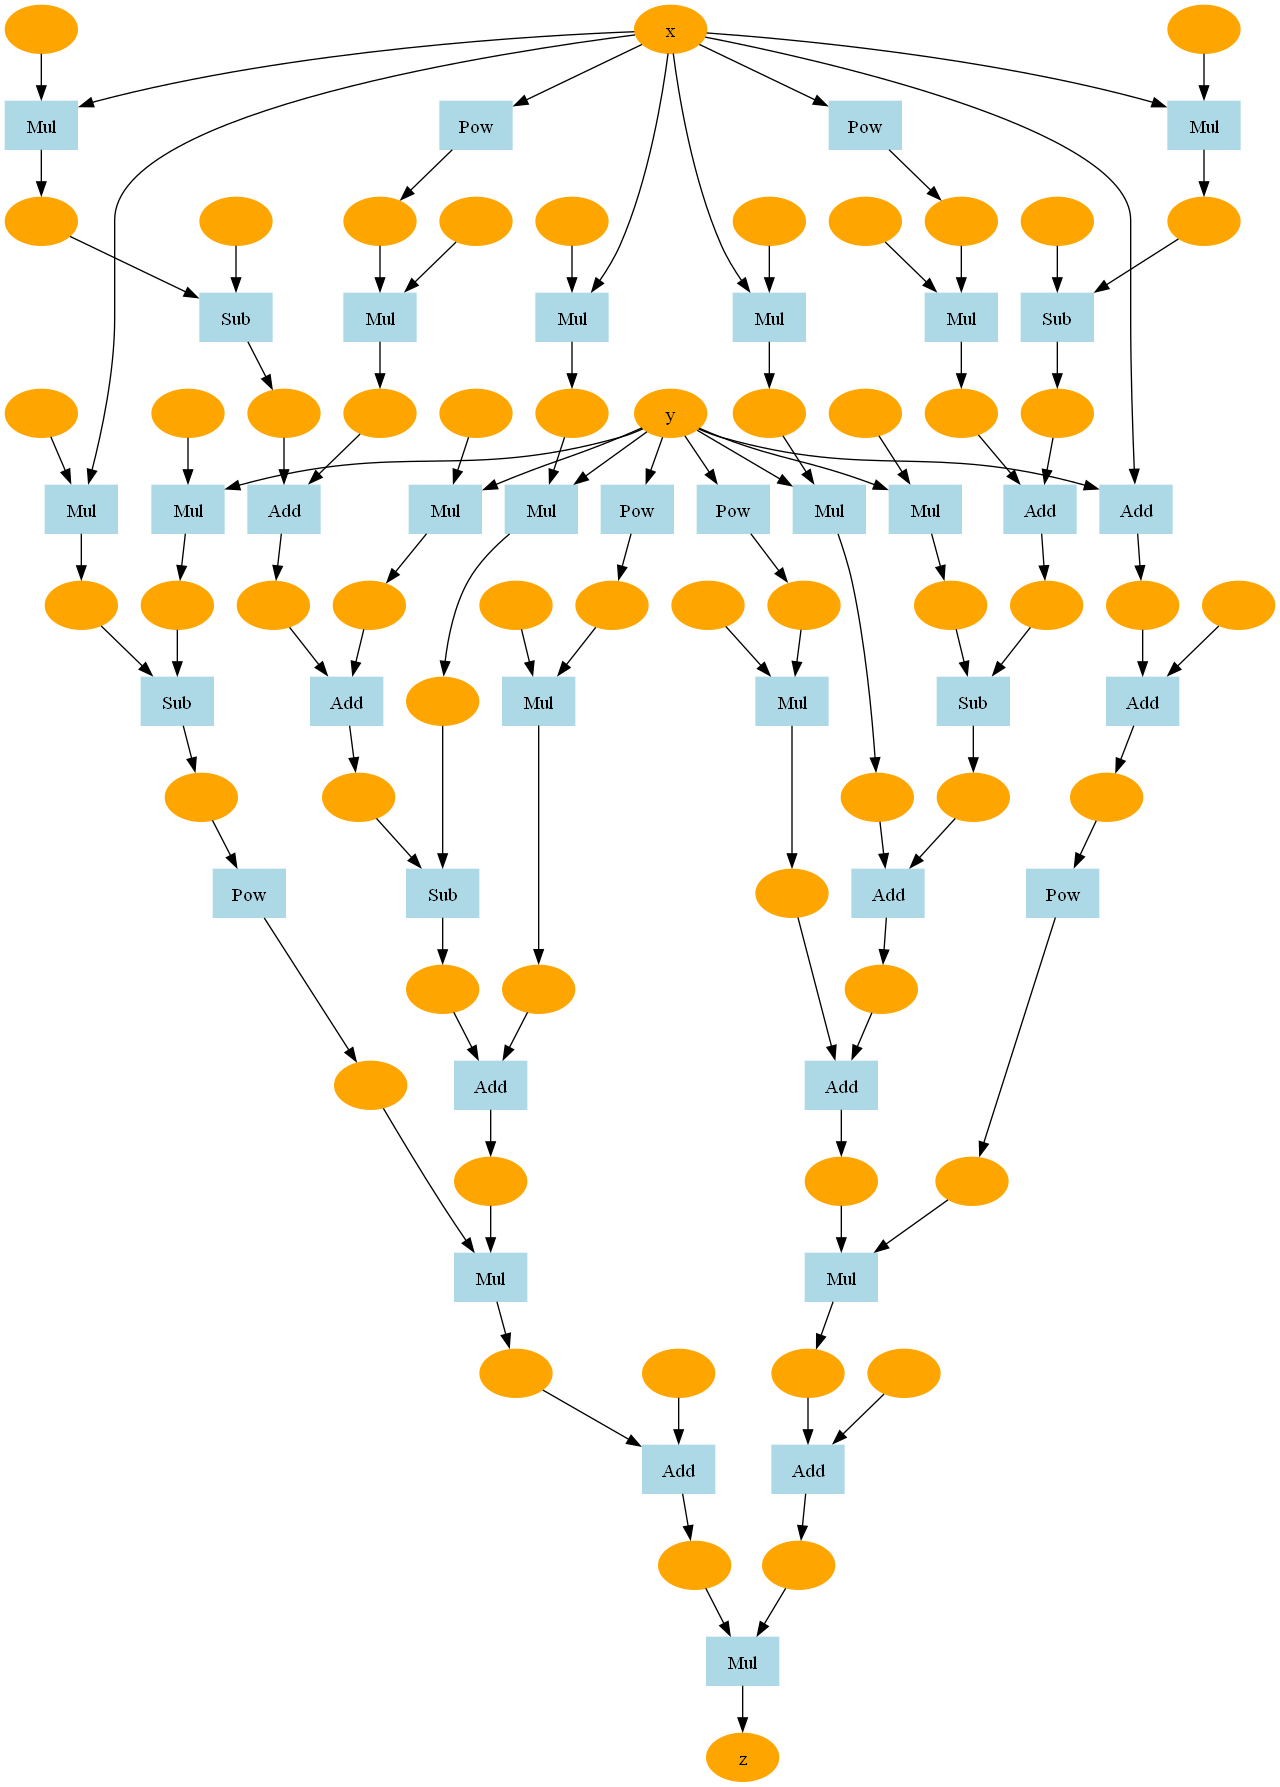

In [8]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable
from dezero.utils import plot_dot_graph

def goldstein(x, y):
    z = (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
        (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
    return z

x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x, y)
z.backward()

x.name = 'x'
y.name = 'y'
z.name = 'z'
plot_dot_graph(z, verbose=False, to_file='golfstein.png')


step27: テイラー展開の微分

27.1 sin関数の実装

In [9]:
import numpy as np
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Function, Variable

In [10]:
class Sin(Function):
    def forward(self, x):
        y = np.sin(x)
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        gx = gy * np.cos(x)
        return gx

In [11]:
def sin(x):
    return Sin()(x)

In [12]:
x = Variable(np.array(np.pi/4))
y = sin(x)
y.backward()

print(y.data)
print(x.grad)

0.7071067811865476
variable(0.7071067811865476)


27.2-3 テイラー展開の実装（sin関数を別の方法で求める）

In [13]:
import math

def my_sin(x, threshold=0.0001):
    y = 0
    for i in range(100000):
        c = (-1) ** i / math.factorial(2 * i + 1)
        t = c * x ** (2 * i + 1)
        y = y + t
        if abs(t.data) < threshold: # テイラー展開を繰り返すほどsin(x)の近似精度が高まり、絶対値は小さくなる（thresholdより小さくなったとき終了させる）
            break
    return y

0.7071064695751781
variable(0.7071032148228457)


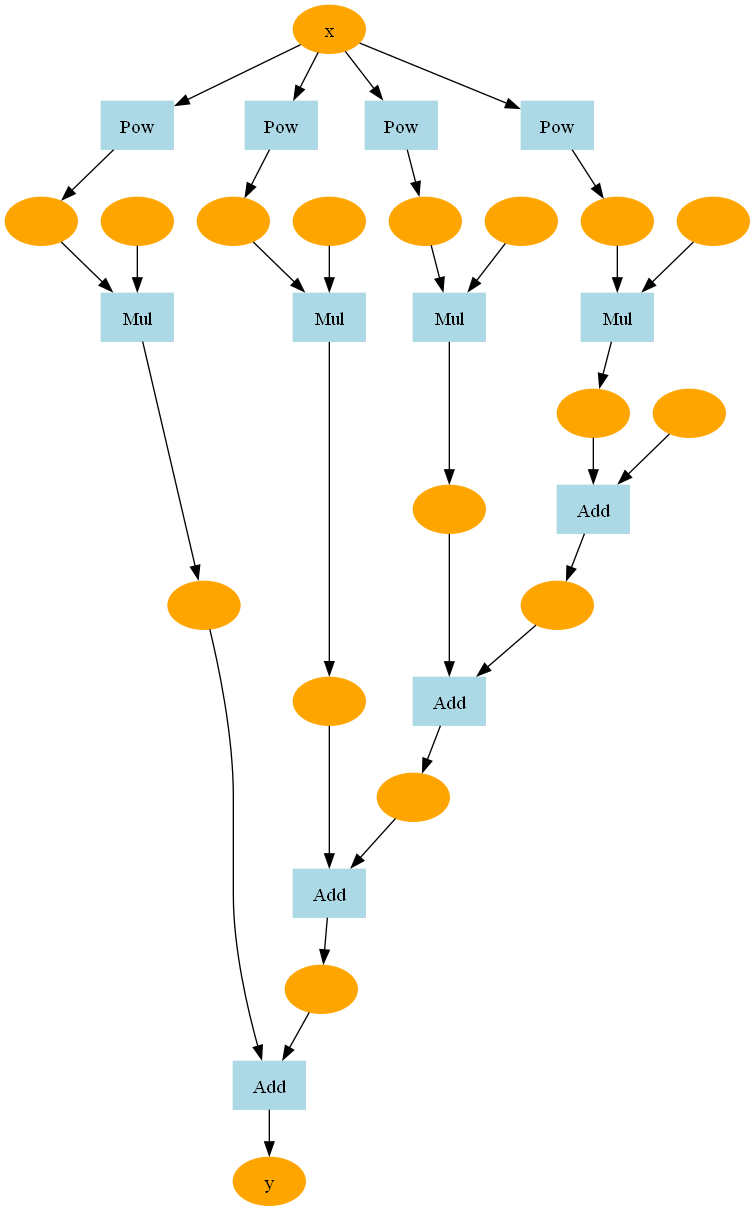

In [14]:
from dezero.utils import plot_dot_graph

x = Variable(np.array(np.pi/4))
y = my_sin(x, threshold=0.0001) # テイラー展開による近似値(thresholdが低いほど制度が高い)
y.backward()

x.name = 'x'
y.name = 'y'

print(y.data)
print(x.grad)
plot_dot_graph(y, verbose=False, to_file='my_sin_0.0001.png')

In [15]:
from dezero.utils import plot_dot_graph

x = Variable(np.array(np.pi/4))
y = my_sin(x, threshold=1e-150) # テイラー展開による近似値(thresholdが低いほど制度が高い)
y.backward()

x.name = 'x'
y.name = 'y'

print(y.data)
print(x.grad)
plot_dot_graph(y, verbose=False, to_file='my_sin_1e-150.png') # thresholdで計算グラフの複雑さをコントロールできる（Run by Defineの強み）

0.7071067811865475
variable(0.7071067811865475)


step28: 関数の最適化

28.1-2 ローゼンブロック関数の微分

In [16]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable

def rosenbrock(x0, x1):
    y = 100 * (x1 - x0 ** 2) ** 2 + (x0 - 1) ** 2
    return y

In [17]:
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))

y = rosenbrock(x0, x1)
y.backward()
print(x0.grad, x1.grad)

variable(-2.0) variable(400.0)


In [18]:
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))
lr = 0.001
iters = 1000

for i in range(iters):
    print(x0, x1)

    y = rosenbrock(x0, x1)
    x0.cleargrad() # アプデされたパラメータを使って新たに微分をするためその時持っている勾配(x0.grad, x1.grad)をリセットする
    x1.cleargrad()
    y.backward()

    x0.data -= lr * x0.grad
    x1.data -= lr * x1.grad


variable(0.0) variable(2.0)
variable(variable(0.002)) variable(variable(1.6))


TypeError: <class 'dezero.core.Variable'> is not supported

step29: ニュートン法を用いた最適化（手計算）

In [ ]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable

def f(x):
    y = x ** 4 - 2 * x ** 2
    return y

def gx2(x):
    return 12 * x ** 2 - 4

x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
    print(i, x)

    y = f(x)
    x.cleargrad()
    y.backward()

    x.data -= x.grad / gx2(x.grad)

step30-31: 高階微分（準備編・理論編）

step32: 高階微分（実装編）

32.1-3 新しいDeZeroへ（逆伝播の計算グラフも生成）

In [ ]:
# simple_core.pyをアプデ（逆伝播の計算グラフを取得し高階微分を可能にする（最適化のニュートン法を可能にするため））
import weakref
import numpy as np
import contextlib


# =============================================================================
# Config
# =============================================================================
class Config:
    enable_backprop = True


@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    try:
        yield
    finally:
        setattr(Config, name, old_value)


def no_grad():
    return using_config('enable_backprop', False)


# =============================================================================
# Variable / Function
# =============================================================================
class Variable:
    __array_priority__ = 200

    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False, create_graph=False):
        if self.grad is None:
            # self.grad = np.ones_like(self.data)
            self.grad = Variable(np.ones_like(self.data)) # 逆伝播の計算グラフも生成できるようにVariableインスタンスにする

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            #  gys = [output.grad for output in f.outputs] # 親（関数）から子(変数)を直接参照する場合（循環参照を引き起こす）
            gys = [output().grad for output in f.outputs]  # 弱参照のデータにアクセスするには（）を加える

            # スイッチのデフォルト(Trueを想定)をFalseに切り替えることで、逆伝播計算中（e.g. gy * x1：これ自体はforwardの計算）でまたFunctionインスタンスが呼ばれその中で逆伝播（２次微分）をConfig.enable_backpropで止める）
            # 逆伝播が終わったらデフォルトに戻す（続きの逆伝播をするため）
            with using_config('enable_backprop', create_graph):
                gxs = f.backward(*gys)
                if not isinstance(gxs, tuple):
                    gxs = (gxs,)

                for x, gx in zip(f.inputs, gxs):
                    if x.grad is None:
                        x.grad = gx
                    else:
                        x.grad = x.grad + gx

                    if x.creator is not None:
                        add_func(x.creator)

                if not retain_grad:
                    for y in f.outputs:
                        # y.grad = None # 親（関数）から子(変数)を直接参照する場合（循環参照を引き起こす）
                        y().grad = None  # 弱参照のデータにアクセスするには（）を加える


def as_variable(obj):
    if isinstance(obj, Variable):
        return obj
    return Variable(obj)


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    def __call__(self, *inputs):
        inputs = [as_variable(x) for x in inputs]

        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        if Config.enable_backprop: # ここで逆伝播のための繋がりを生成
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            # self.outputs = outputs # 循環参照を引き起こす（親から子、子から親が参照し合っている）# Jupyterではこれでやる
            self.outputs = [weakref.ref(output) for output in outputs]

        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()


# =============================================================================
# 四則演算 / 演算子のオーバーロード
# =============================================================================
class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

    def backward(self, gy):
        return gy, gy


def add(x0, x1):
    x1 = as_array(x1)
    return Add()(x0, x1)


class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y

    def backward(self, gy):
        # x0, x1 = self.inputs[0].data, self.inputs[1].data
        x0, x1 = self.inputs # Variableインスタンスをそのまま計算に使う（順伝播みたいに）
        return gy * x1, gy * x0 # Variableの特殊メソッドで演算子をそのまま使って計算できる(この時新たなFunctionインスタンスのcallメソッドが呼ばれる)


def mul(x0, x1):
    x1 = as_array(x1)
    return Mul()(x0, x1)


class Neg(Function):
    def forward(self, x):
        return -x

    def backward(self, gy):
        return -gy


def neg(x):
    return Neg()(x)


class Sub(Function):
    def forward(self, x0, x1):
        y = x0 - x1
        return y

    def backward(self, gy):
        return gy, -gy


def sub(x0, x1):
    x1 = as_array(x1)
    return Sub()(x0, x1)


def rsub(x0, x1):
    x1 = as_array(x1)
    return Sub()(x1, x0)


class Div(Function):
    def forward(self, x0, x1):
        y = x0 / x1
        return y

    def backward(self, gy):
        # x0, x1 = self.inputs[0].data, self.inputs[1].data
        x0, x1 = self.inputs
        gx0 = gy / x1
        gx1 = gy * (-x0 / x1 ** 2)
        return gx0, gx1


def div(x0, x1):
    x1 = as_array(x1)
    return Div()(x0, x1)


def rdiv(x0, x1):
    x1 = as_array(x1)
    return Div()(x1, x0)


class Pow(Function):
    def __init__(self, c):
        self.c = c

    def forward(self, x):
        y = x ** self.c
        return y

    def backward(self, gy):
        # x = self.inputs[0].data
        x = self.inputs
        c = self.c

        gx = c * x ** (c - 1) * gy
        return gx


def pow(x, c):
    return Pow(c)(x)

# 演算子のオーバーロード（Variableクラスに特殊メソッドの実装＝演算子を直接使えるようにする）
def setup_variable():
    # Variableクラスに直接書かず関数でまとめてVariableクラスに追加する
    Variable.__add__ = add
    Variable.__radd__ = add
    Variable.__mul__ = mul
    Variable.__rmul__ = mul
    Variable.__neg__ = neg
    Variable.__sub__ = sub
    Variable.__rsub__ = rsub
    Variable.__truediv__ = div
    Variable.__rtruediv__ = rdiv
    Variable.__pow__ = pow


32.4 __init__.pyの変更（simple_coreからcoreへ）

In [ ]:
# dezeroパッケージが呼び出されると自動でこのファイル（以下のコード）が実行される

# =============================================================================
# step23.pyからstep32.pyまではsimple_coreを利用
is_simple_core = False  # True
# =============================================================================

# dezeroパッケージが呼出されると共に、コア機能が呼び出さる（dezerと打つだけでdezero.core_simpleを扱える）
if is_simple_core:
    from dezero.core_simple import Variable
    from dezero.core_simple import Function
    from dezero.core_simple import using_config
    from dezero.core_simple import no_grad
    from dezero.core_simple import as_array
    from dezero.core_simple import as_variable
    from dezero.core_simple import setup_variable
else:
    from dezero.core import Variable
    from dezero.core import Function
    from dezero.core import using_config
    from dezero.core import no_grad
    from dezero.core import as_array
    from dezero.core import as_variable
    from dezero.core import setup_variable

setup_variable() # dezeroパッケージが呼び出されると共に、演算子のオーバーロード機能をVariableクラスに追加


step33: ニュートン法を使った最適化（自動計算）

33.1 2階微分を求める

In [ ]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable

def f(x):
    y = x ** 4 - 2 * x **2
    return y

x = Variable(np.array(2.0))
y = f(x)
print(y)
y.backward(create_graph=True)
print(x.grad)

gx = x.grad
x.cleargrad() # xの微分だけ手動で消す必要がある（そうしないと１階微分と２階微分の合計が出力される）
gx.backward()
print(x.grad)

33.2 ニュートン法による最適化（自動）

In [ ]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable

def f(x):
    y = x ** 4 - 2 * x **2
    return y

x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
    print(i, x)

    y = f(x)
    x.cleargrad()
    y.backward(create_graph=True) # １階微分

    gx = x.grad
    x.cleargrad()
    gx.backward() # ２階微分
    gx2 = x.grad

    x.data -= gx.data / gx2.data # ニューロン最適化

step34: sin関数の高階微分

34.1 sin関数の実装(dezero.function)

In [ ]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Function

class Sin(Function):
    def forward(self, x):
        y = np.sin(x)
        return y

    def backward(self, gy):
        x, = self.inputs
        gx = gy * cos(x) # dezero.functionに実装
        return gx

34.2 cos関数の実装

In [ ]:
class Cos(Function):
    def forward(self, x):
        y = np.cos(x)
        return y

    def backward(self, gy):
        x, = self.inputs
        gx = gy * -sin(x)
        return gx

def cos(x):
    return Cos()(x)

34.3 sin関数の高階微分

In [ ]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable
import dezero.functions as F

x = Variable(np.array(1.0))
y = F.sin(x)
y.backward(create_graph=True)

for i in range(3):
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)
    print(x.grad)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable
import dezero.functions as F

# Variableと関数を定義
x = Variable(np.linspace(-7, 7, 200))
y = F.sin(x)
y.backward(create_graph=True)

# ログにデータを記録
logs = [y.data.flatten()]

for i in range(3):
    print(x.grad.data.flatten())
    logs.append(x.grad.data.flatten())
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)

# ラベルと色を指定してプロット
labels = ["y=sin(x)", "y'", "y''", "y'''"]
colors = ['blue', 'orange', 'green', 'red']

for i, v in enumerate(logs):
    plt.plot(x.data, logs[i], label=labels[i], color=colors[i])

plt.legend(loc='lower right')
plt.show()


step35: 高階微分の計算グラフ

In [ ]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Function

class Tanh(Function):
    def forward(self, x):
        y = np.tanh(x)
        return y

    def backward(self, gy):
        y = self.outputs[0]()
        gx = gy * (1 - y * y)
        return gx

def tanh(x):
    return Tanh()(x)

35.3 高階微分の計算グラフの可視化

In [ ]:
import numpy as np
from dezero import Variable
from dezero.utils import plot_dot_graph
import dezero.functions as F

x = Variable(np.array(1.0))
y = F.tanh(x)
x.name = 'x'
y.name = 'y'
y.backward(create_graph=True)

iters = 0
for i in range(iters):
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)

# 計算グラフを描画
gx = x.grad
gx.name = 'gx' + str(iters+1)
plot_dot_graph(gx, verbose=False, to_file = 'tang.png')

step36: 高階微分以外の用途

In [8]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable

x = Variable(np.array(2.0))
y = x ** 2
y.backward(create_graph=True)
gx = x.grad # gxは値ではなく計算グラフ（式）
x.cleargrad()

z = gx ** 3 + y
z.backward()
print(x.grad)

variable(100.0)


step37: テンソルを使う

37.1-2 テンソルを使用したときの逆伝播

In [ ]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable
from dezero import Function as F

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
c = Variable(np.array([[10, 20, 30], [40, 50, 60]]))
t = x + c
y = F.sum(t)

step38: 形状を変える関数

38.1 reshape関数の実装

In [ ]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Function, as_variable

class Reshape(Function):
    def __init__(self, shape):
        self.shape = shape

    def forward(self, x):
        self.x_shape = x.shape
        y = x.reshape(self.shape)
        return y

    def backward(self, gy):
        return reshape(gy, self.x_shape)


def reshape(x, shape):
    if x.shape == shape:
        return as_variable(x)
    return Reshape(shape)(x)

In [ ]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import functions as F, Variable

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.reshape(x, (6,))
y.backward(retain_grad=True)
print(x.grad)

38.2 Variableからreshapeを使う：いちいちF.reshape(x, (6,))と打たずx.reshape(6,)で同じことができるようにする

In [ ]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
import dezero.functions

# class Variable
def reshape(self, *shape):
    if len(shape) == 1 and isinstance(shape[0], (tuple, list)):
        shape = shape[0]
    return dezero.functions.reshape(self, shape) # F.reshapeを使うと循環インポートになるためここで直接呼ぶ

In [ ]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable

x = Variable(np.random.randn(1, 2, 3))
y = x.reshape(6,)
print(y)

38.3 行列の転置

In [ ]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Function

class Transpose(Function):
    def forward(self, x):
        y = np.transpose(x)
        return y

    def backward(self, gy):
        gx = transpose(gy) # np.tranposeを使わないのは計算グラフ作成のため(Transposeクラス順伝播を使えば自動で計算グラフが構築される)
        return gx

def transpose(x):
    return Transpose()(x)

In [19]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import functions as F, Variable

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.transpose(x)
y.backward()
print(x.grad)

variable([[1 1 1]
          [1 1 1]])


In [ ]:
# class Variable
def transpose(self):
    return dezero.functions.transpose(self)

@property
def T(self):
    return dezero.functions.transpose(self) # x.T(インスタンス減数)でもx.transpose()でも同じことができる

In [20]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable

x = Variable(np.random.rand(2, 3))
y = x.transpose()
print(y)
y = x.T
print(y)


variable([[0.77604721 0.44462517]
          [0.93259546 0.48043634]
          [0.34357729 0.75374945]])
variable([[0.77604721 0.44462517]
          [0.93259546 0.48043634]
          [0.34357729 0.75374945]])


In [ ]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Function

class Transpose(Function):
    def __init__(self, axes=None):
        self.axes = axes

    def forward(self, x):
        y = x.transpose(self.axes) # Variable内のtransposeを使って倒置
        return y

    def backward(self, gy):
        if self.axes is None:
            return transpose(gy)

        axes_len = len(self.axes)
        inv_axes = tuple(np.argsort([ax % axes_len for ax in self.axes]))
        return transpose(gy, inv_axes)

def transpose(x, axes=None):
    return Transpose(axes)(x)


step 39: 和を求める関数

39.1-2 sum関数の実装

In [ ]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Function

class Sum(Function):
    def forward(self, c):
        self.x_shape = x.shape
        y = x.sum()
        return y

    def backward(self, gy):
        gx = broadcast_to(gy, self.x_shape) # 後のステップで搭載
        return gx

def sum(x):
    return Sum()(x)

In [23]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable, functions as F

x = Variable(np.array([[1, 2, 3],[4, 5, 6]]))
y = F.sum(x)
y.backward()
print(y)
print(x.grad)

AttributeError: 'Sum' object has no attribute 'acis'

39.3 axisとkeepdimsを搭載したsum関数

In [ ]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Function, utils

class Sum(Function):
    def __init__(self, axis, keepdims):
        self.axis = axis
        self.keepdims = keepdims

    def forward(self, x):
        self.x_shape = x.shape
        y = x.sum(axis=self.acis, keepdims = self.keepdims)
        return y

    def backward(self, gy):
        gy = utils.reshape_sum_backward(gy, self.x_shape, self.axis, self.keepdims) # gyの形状を微調整
        gx = broadcast_to(gy, self.x_shape) # 後のステップで搭載
        return gx

def sum(x, axis=None, keepdims=False):
    return Sum(axis, keepdims)(x)

In [ ]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Function

class Sum(Function):
    def forward(self, c):
        self.x_shape = x.shape
        y = x.sum()
        return y

    def backward(self, gy):
        gx = broadcast_to(gy, self.x_shape) # 後のステップで搭載
        return gx

def sum(x):
    return Sum()(x)

In [ ]:
# Variable class
def sum(self, axis=None, keepdims=False):
    return dezero.functions.sum(self, axis, keepdims)

In [2]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable, functions as F

x = Variable(np.array([[1, 2, 3],[4, 5, 6]]))
y = F.sum(x)
y.backward()
print(y)
print(x.grad)

x = Variable(np.random.randn(2, 3, 4, 5))
y = x.sum(keepdims=True)
print(y.shape)

variable(21)
variable([[1 1 1]
          [1 1 1]])
(1, 1, 1, 1)


step40: ブロードキャスト関数

40.1-2 broadcast_to関数とsum_to関数

In [ ]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Function

class BroadcastTo(Function):
    def __init__(self, shape):
        self.shape = shape

    def forward(self, x):
        self.x_shape = x.shape # 入力xの形状を覚えておく
        y = np.broadcast_to(x, self.shape)
        return y

    def backward(self, gy):
        gx = sum_to(gy, self.x_shape)
        return gx

def broadcast_to(x, shape):
    if x.shape == shape:
        return as_variable
    return BroadcastTo(shape)(x)

In [ ]:
from dezero import utils

class SumTo(Function):
    def __init__(self, shape):
        self.shape = shape

    def forward(self, x):
        self.x_shape = x.shape
        y = utils.sum_to(x, self.shape) # 実際の演算はutilsの関数で行われている
        return y

    def backward(self, gy):
        gx = broadcast_to(gy, self.x_shape)
        return gx

def sum_to(x, shape):
    if x.shape == shape:
        return as_variable(x)
    return SumTo(shape)(x)

40.3 Dezeroのブロードキャストへの対応（現状はndarrayのbroadcast機能に依存しているため逆伝播ができない）

In [ ]:
class Add(Function):
    def forward(self, x0, x1):
        self.x0_shape, self.x1_shape = x0.shape, x1.shape # 入力の形状を保持（逆伝播の時元の形状に戻すため）
        y = x0 + x1
        return y

    def backward(self, gy):
        gx0, gx1 = gy, gy
        # 前伝播計算時に形状が違っていたら（ブロードキャストによって形状が補正されていたら）
        if self.x0_shape != self.x1_shape:
            # 勾配の形状を入力の形状にしながらその合計を求める
            gx0 = dezero.functions.sum_to(gx0, self.x0_shape)
            gx1 = dezero.functions.sum_to(gx1, self.x1_shape)
        return gy, gy

# Mul,Sub, Divなどにも同じ修正

In [3]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable

x0 = Variable(np.array([1, 2, 3]))
x1 = Variable(np.array([10]))

y = x0 + x1
print(y)

y.backward()
print(x1.grad)

variable([11 12 13])
variable([3])


step41 行列の積

41.1-2 行列の形状チェック

In [1]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Function

class MatMul(Function):
    def forward(self, x, W):
        y = x.dot(W)
        return y

    def backward(self, gy):
        x, W = self.omputs
        gx = matmul(gy, W.T)
        gW = matmul(x.T, gy)
        return gx, gW

def matmul(x, W):
    return MatMul()(x, W)

In [1]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable
import dezero.functions as F
import numpy as np

x = Variable(np.random.randn(2, 3))
W = Variable(np.random.randn(3, 4))
y = F.matmul(x, W)
y.backward()

print(x.grad.shape)
print(W.grad.shape)

(2, 3)
(3, 4)


: 

step42: 線形回帰

42.1-2 線形回帰の実装

In [6]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable
import dezero.functions as F

np.random.seed(0)
x = np.random.rand(100, 1)
y = 5 + 2 * x + np.random.rand(100, 1)
x, y = Variable(x), Variable(y)

W = Variable(np.zeros((1, 1)))
b = Variable(np.zeros(1))

def predict(x):
    y= F.matmul(x, W) + b
    return y

In [7]:
def mean_squared_error(x0, x1):
    diff = x0 - x1
    return F.sum(diff ** 2) / len(diff)

lr = 0.1
iters = 100

for i in range(iters):
    y_pred = predict(x)
    loss = mean_squared_error(y, y_pred)

    W.cleargrad()
    b.cleargrad()
    loss.backward()

    W.data -= lr * W.grad.data
    b.data -=lr * b.grad.data
    print(W, b, loss)

variable([[0.64433458]]) variable([1.29473389]) variable(42.296340129442335)
variable([[1.12672345]]) variable([2.26959351]) variable(23.97380754378544)
variable([[1.48734571]]) variable([3.00386712]) variable(13.609686745040522)
variable([[1.75641886]]) variable([3.557186]) variable(7.747049961219976)
variable([[1.95666851]]) variable([3.97439789]) variable(4.43057410592155)
variable([[2.10518573]]) variable([4.28923203]) variable(2.554280381353593)
variable([[2.21482401]]) variable([4.52705574]) variable(1.492599869047195)
variable([[2.29524981]]) variable([4.70694745]) variable(0.8916952181756939)
variable([[2.35373273]]) variable([4.84325585]) variable(0.5514270962227455)
variable([[2.39573972]]) variable([4.9467725]) variable(0.3585915308319281)
variable([[2.425382]]) variable([5.02561369]) variable(0.24915731977561134)
variable([[2.44575118]]) variable([5.08588371]) variable(0.1869065876539789)
variable([[2.45917205]]) variable([5.13217364]) variable(0.1513533629631488)
variable(

Dezeroの平均２乗誤差実装（メモリ効率化）

In [ ]:
class MeanSquaredError(function):
    def forward(self, x0, x1):
        diff = x0 - x1
        y = (diff ** 2).sum() / len(diff)
        return y

    def backward(self, gy):
        x0, x1 = self.inputs
        diff = x0 - x1
        gy = broadcast_to(gy, diff.shape)
        gx0 = gy * diff * (2. / len(diff))
        gx1 = -gx0
        return gx0, gx1

def mean_squared_error(x0, x1):
    MeanSquaredError()(x0, x1)

step43: ニューラルネットワーク

43.1 Dezeroのlinear関数（２つの関数を使うがメモリ効率を改善した版）

In [1]:
def linear_simple(x, W, b=None):
    x, W = as_variable(x), as_variable(W)
    t = matmul(x, W)
    if b is None:
        return t

    y = t + b
    t.data = None # 逆伝播では実質必要ない
    return y

43.2 非線形なデータセット

In [2]:
from math import exp

def sigmoid(x):
    x = as_variable(x)
    y = 1 / (1 + exp(-x))
    return y

43.4 ニューラルネットワークの実装

In [1]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable
import dezero.functions as F

# データセット
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

# 1. 重みの初期化
I, H, O = 1, 10, 1
W1 = Variable(0.01 * np.random.randn(I, H))
b1 = Variable(np.zeros(H))
W2 = Variable(0.01 * np.random.randn(H, O))
b2 = Variable(np.zeros(O))

# 2. ニューラルネットワークの推論
def predict(x):
    y = F.linear(x, W1, b1)
    y = F.sigmoid(y)
    y = F.linear(y, W2, b2)
    return y

lr = 0.2
iters = 10000

# 3. ニューラルネットワークの学習
for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)
    print(f"Loss: {loss}")
    W1.cleargrad()
    b1.cleargrad()
    W2.cleargrad()
    b2.cleargrad()
    loss.backward()

    W1.data -= lr * W1.grad.data
    b1.data -= lr * b1.grad.data
    W2.data -= lr * W2.grad.data
    b2.data -= lr * b2.grad.data

    if i % 1000 == 0:
        print(loss)

Loss: variable(0.8473695850105871)
variable(0.8473695850105871)
Loss: variable(0.6004598151124442)
Loss: variable(0.5608541317049301)
Loss: variable(0.5543321590937468)
Loss: variable(0.5532308847575004)
Loss: variable(0.552990067407093)
Loss: variable(0.5528865414937602)
Loss: variable(0.5528046462817284)
Loss: variable(0.5527260119904448)
Loss: variable(0.5526477067342384)
Loss: variable(0.5525692472582907)
Loss: variable(0.552490537019683)
Loss: variable(0.5524115403606621)
Loss: variable(0.5523322310791146)
Loss: variable(0.552252584355981)
Loss: variable(0.5521725754744862)
Loss: variable(0.5520921796161398)
Loss: variable(0.5520113718201729)
Loss: variable(0.5519301269704685)
Loss: variable(0.5518484197858643)
Loss: variable(0.5517662248112853)
Loss: variable(0.5516835164088087)
Loss: variable(0.5516002687487207)
Loss: variable(0.5515164558004954)
Loss: variable(0.5514320513237089)
Loss: variable(0.5513470288588769)
Loss: variable(0.5512613617182195)
Loss: variable(0.551175022976

ステップ44: パラメータをまとめるレイヤ

44.Parameterクラスの実装（性質はVariableと同じ）

In [2]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable

class Prameter(Variable):
    pass

44.2 Layerクラスの実装

In [4]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Parameter

class Layer:
    def __init__(self):
        self._params = set()

    def __setattr__(self, name, value):# 特殊メソッドsetattrをカスタマイズ（Parameterインスタンスのときだけその変数名と値を格納）
        if isinstance(value, Parameter):
            self._params.add(name)
        super().__setattr__(name, value) # 親クラス(object:全てにおける基底)のsetattrメソッド（デフォルト）を呼ぶ

In [8]:
# Jupyter用（Jupyterだとinitでparamsが初期化される前にsetattrが呼ばれてparamsがないとエラーが出る）
import sys
import numpy as np
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Parameter

class Layer:
    def __init__(self):
        super().__setattr__('_params', set())  # ここで親クラスの setattr を使って _params を初期化

    def __setattr__(self, name, value):
        if isinstance(value, Parameter):
            self._params.add(name)
        super().__setattr__(name, value)

# テスト用のコード
layer = Layer()

# layerにパラメータ名(p1など)とその値を格納（layerオブジェクトのdictに格納される)
layer.p1 = Parameter(np.array(1))
layer.p2 = Parameter(np.array(2))
layer.p3 = Variable(np.array(2))
layer.p4 = 'test'

print(layer._params)
print('--------------------------')

for name in layer._params:
    print(name, layer.__dict__[name]) # 変数名とその値


{'p1', 'p2'}
--------------------------
p1 variable(1)
p2 variable(2)


In [3]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Parameter

class Layer:
    def __init__(self):
        self._params = set()

    def __setattr__(self, name, value):
        if isinstance(value, Parameter):
            self._params.add(name)
        super().__setattr__(name, value)

    # 前伝播の支持とその入出力の保持
    def __call__(self, *inputs):
        outputs = self.forward(*inputs)
        if not isinstance(outputs, tuple):
            outputs = (outputs, )
        self.inputs = [weakref.ref(x) for x in inputs]
        self.outputs = [weakref.ref(y) for y in inputs]
        return outputs if len(outputs) > 1 else outputs[0]

    # 具体的な前伝播計算は継承作のクラスで実装
    def forward(self, inputs):
        raise NotImplementedError()

    # 格納したパラメータの値を順に全て取り出す
    def params(self):
        for name in self._params:
            yield self.__dict__[name] # yieldは処理を途中で停止して、その途中から再び再開できる

    # Layerインスタンスにあるパラメータの勾配を全て消去
    def cleargrads(self):
        for param in self.params():
            param.cleargrad()

44.3 Linearクラスの実装

In [4]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Parameter
import dezero.functions as F
from dezero.layers import Layer

class Linear(Layer):
    def __init__(self, out_size, nobias=False, dtype=np.float32, in_size=None):
        super().__init__() # Layerクラスの初期化メソッドを呼ぶ（Linearにも初期化メソッドが設定されているため個別に呼ぶ必要がある）
        self.in_size = in_size
        self.out_size = out_size
        self.dtype = dtype

        self.W = Parameter(None, name='W')
        if self.in_size is not None: # 入力サイズが指定されているなら
            self._init_W() # Wの初期化をする
            # 入力サイズが指定されていないなら前伝播（実際にデータが入力される）時にWを初期化

        if nobias:
            self.b = None
        else:
            self.b = Parameter(np.zeros(out_size, dtype=dtype), name='b')

    def _init_W(self):
        I, O = self.in_size, self.out_size
        W_data = np.random.randn(I, O).astype(self.dtype) * np.sqrt(1 / I)
        self.W.data = W_data

    def forward(self, x):
        # データを流すタイミングで重みを初期化
        if self.W.data is None:
            self.in_size = x.shape[1]
            self._init_W()

            y = F.linear(x, self.W, self.b)
            return y

44.4 Layerを使ったニューラルネットワークの実装

In [1]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable
import dezero.functions as F
import dezero.layers as L

# データセット
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

l1 = L.Linear(10) # 出力サイズ指定だけでいい(重みの入力サイズはデータが流された時に初期化される)
l2 = L.Linear(1)
def predict(x):
    y = l1.forward(x)
    assert y is not None, "Output of first Linear layer is None"
    # print("Output after first linear layer:", y)
    y = F.sigmoid(y)
    # print("Output after sigmoid:", y)
    y = l2.forward(y)
    # print("Output after second linear layer:", y)
    return y

lr = 0.2
iters = 10000

for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)

    l1.cleargrads()
    l2.cleargrads()
    loss.backward()

    for l in [l1, l2]:
        for p in l.params():
            p.data -= lr * p.grad.data
    if i % 1000 == 0:
        print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350177)
variable(0.12311905720649349)
variable(0.07888166506355149)
variable(0.07655073683421633)
variable(0.07637803086238223)
variable(0.07618764131185574)


step45: レイヤをまとめるレイヤ

45.1 Layerクラスの拡張

In [1]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Parameter

class Layer:
    def __init__(self):
        self._params = set()

    def __setattr__(self, name, value):
        if isinstance(value, (Parameter, Layer)): # 1. Layerも_params追加する
            self._params.add(name)
        super().__setattr__(name, value)

    # 前伝播の支持とその入出力の保持
    def __call__(self, *inputs):
        outputs = self.forward(*inputs)
        if not isinstance(outputs, tuple):
            outputs = (outputs, )
        self.inputs = [weakref.ref(x) for x in inputs]
        self.outputs = [weakref.ref(y) for y in inputs]
        return outputs if len(outputs) > 1 else outputs[0]

    # 具体的な前伝播計算は継承作のクラスで実装
    def forward(self, inputs):
        raise NotImplementedError()

    # 格納したパラメータの値を順に全て取り出す
    def params(self):
        for name in self._params:
            obj = self.__dict__[name] # 2. パラメータの値またはLayerをobjにする

            if isinstance(obj, Layer): # 3. Layerならパラメータを取り出す
                yield from obj.params() # yield from: ジェネレータを使って新しいジェネレータを作る
            else:
                yield obj # 4. パラメータならそのままパラメータを返す

    # Layerインスタンスにあるパラメータの勾配を全て消去
    def cleargrads(self):
        for param in self.params():
            param.cleargrad()

In [3]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable
import dezero.functions as F
import dezero.layers as L

model = Layer() # modelが全体のレイヤを管理するレイヤ
# model に実際推論に使うレイヤを追加
model.l1 = L.Linear(5)
model.l2 = L.Linear(3)

# 推論
def predict(model, x): # modelも代入
    y = model.l1(x)
    y = F.sigmoid(y)
    y = model.l2(y)
    return y

# 全てのパラメータにアクセス(modelを始点に再帰的にパラメータが呼ばれる)
for p in model.params():
    print(p)

# 全てのパラメータの勾配をリセット
model.cleargrads()

45.2 Modelクラス

In [1]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Layer
from dezero import utils

class Model(Layer):
    # Layerクラスの機能に計算グラフの図をプロットする機能を追加
    def plot(self, *inputs, to_file='model.png'):
        y = self.forward(*inputs)
        # 前伝播の計算を通して計算グラフを画像化
        return utils.plot_dot_graph(y, verbose=True, to_file=to_file)

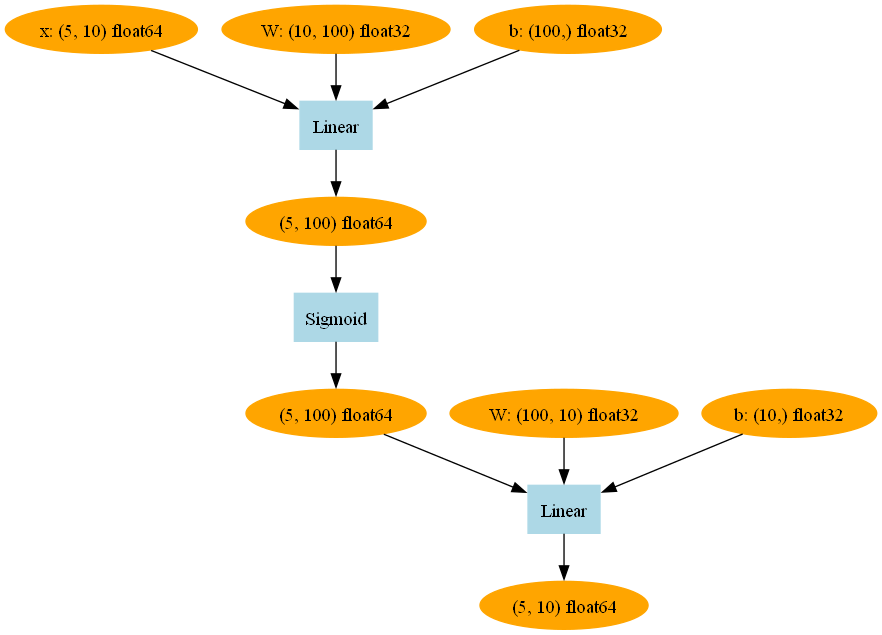

In [2]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable
import dezero.functions as F
import dezero.layers as L

class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y


x = Variable(np.random.randn(5, 10), name='x')
model = TwoLayerNet(100, 10)
model.plot(x)


45.3 Modelを使って問題を解く

In [4]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable, Model
import dezero.functions as F
import dezero.layers as L

# データセットの生成
np.random.seed(0)
x = np.random.rand(100,1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

# ハイパーパラメータの設定
lr = 0.2
max_iter = 10000
hidden_size = 10

# モデルの定義
class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y

model = TwoLayerNet(hidden_size, 1)

# 学習
for i in range(max_iter):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()
    loss.backward()

    for p in model.params():
        p.data -= lr * p.grad.data
    if i % 1000 == 0:
        print(loss)


variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350177)
variable(0.12311905720649349)
variable(0.07888166506355149)
variable(0.07655073683421633)
variable(0.07637803086238223)
variable(0.07618764131185574)


45.4 MLPクラス(Multi-Layer Perception): 汎用的な全結合層のネットワーク

In [6]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable, Model
import dezero.functions as F
import dezero.layers as L

class MLP(Model):
    def __init__(self, fc_output_sizes, activation=F.sigmoid): # fc_output_sizes: e.g.(10, 1); ２つのレイヤで出力がそれぞれ１０と１
        super().__init__()
        self.activation = activation # 活性化関数(デフォルトはsigmoid)
        self.layers = []

        for i, out_size in enumerate(fc_output_sizes):
            layer = L.Linear(out_size)
            setattr(self, 'l' + str(i), layer) # 汎用的なself.l1 = L.Linear(out_size)
            self.layers.append(layer)

    def forward(self, x):
        for l in self.layers[:-1]: # １番最後のレイヤ以外
            x = self.activation(l(x)) # 活性化関数に通す
            return self.layers[-1](x) # 最後は全結合層で出力

model = MLP((10, 1)) #2層
model = MLP((10, 20, 30, 40, 1)) # 5層

step46: Optimizerによるパラメータ更新

Optimizerクラスの実装

In [1]:
class Optimizer:
    def __init__(self):
        self.target = None
        self.hooks = []

    def setup(self, target): # target: ModelかLayer
        self.target = target
        return self

    def update(self):
        # None以外のパラメータをリストにまとめる
        params = [p for p in self.target.params() if p.grad is not None]

        # 前処理（オプション）
        for f in self.hooks:
            f(params)

        for param in params:
            self.update_one(param)

    def update_one(self, param):
        raise NotImplementedError()

    def add_hook(self, f):
        self.hooks.append(f)

46.2 SGDクラスの実装

In [2]:
class SGD(Optimizer):
    def __init__(self, lr=0.01):
        super().__init__()
        self.lr = lr

    def update_one(self, param):
        param.data -= self.lr * param.grad.data

46.4 SGDクラスを使って問題を解く

In [6]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable, Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L
from dezero.models import MLP

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
max_iter = 10000
hidden_size = 10

model = MLP((hidden_size, 1))
optimizer = optimizers.SGD(lr)
optimizer.setup(model)

for i in range(max_iter):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()
    loss.backward()

    optimizer.update()
    if i % 1000 == 0:
        print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350177)
variable(0.12311905720649349)
variable(0.07888166506355149)
variable(0.07655073683421633)
variable(0.07637803086238223)
variable(0.07618764131185574)


46.4 SGD以外の最適化手法

In [8]:
import numpy as np

class MomentumSGD(Optimizer):
    def __init__(self, lr = 0.01, momentum=0.9):
        super().__init__()
        self.lr = lr
        self.momentum = momentum
        self.vs = {}

    def update_one(self, param):
        v_key = id(param)
        if v_key not in self.vs:
            self.vs[v_key] = np.zeros_like(param.data)

        v = self.vs[v_key]
        v *= self.momentum
        v -= self.lr * param.grad.data
        param.data += v

step47: ソフトマックス関数と交差エントロピー誤差

47.1-付録B get_item関数の実装

In [ ]:
class GetItem(Function):
    def __init__(self, slices):
        self.slices = slices

    def forward(self, x):
        y = x[self.slices]
        return y

    def backward(self, gy):
        x, = self.inputs
        f = GetItemGrad(self.slices, x.shape)
        return f(gy)

class GetItemGrad(Function):
    def __init__(self, slices, in_shape):
        self.slices = slices

    def forward(self, gy):
        gx = np.zeros(self.in_shape)
        np.add.at(gx, self.slices, gy)
        return gx

    def backward(self, ggx):
        return get_item(ggx, self.slices)

def get_item(x, slices):
    return GetItem(slices)(x)

47.2 ソフトマックス関数

In [3]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable, as_variable
from dezero import optimizers
import dezero.functions as F

def softmax1d(x):
    x = as_variable(x)
    y = F.exp(x)
    sum_y = F.sum(y)
    return y / sum_y

In [4]:
from dezero.models import MLP

model =MLP((10, 3))
x = Variable(np.array([[0.2, -0.4]]))
y = model(x)
p = softmax1d(y)
print(y)
print(p)

variable([[-1.16897352  0.6246793  -0.56723431]])
variable([[0.11316491 0.68027624 0.20655885]])


In [4]:
def softmax_simple(x, axis=1):
    x = as_variable(x)
    y = exp(x)
    sum_y = sum(y, axis=axis, keepdims=True)
    return y / sum_y

47.3 交差エントロピー誤差

In [1]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable, as_variable
from dezero import optimizers
from dezero.functions import clip,log

def softmax_cross_entropy_simple(x, t):
    x, t = as_variable(x), as_variable(t)
    N = x.shape[0]
    p = softmax_simple(x)
    p = clip(p, 1e-15, 1.0)
    log_p = log(p)
    tlog_p = log_p[np.arrange(N), t.data]
    y = -1 * sum(tlog_p) / N
    return y

In [1]:
import numpy as np
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable, as_variable
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP

model =MLP((10, 3))

x = np.array([[0.2, -0.4], [0.3, 0.5], [1.3, -3.2], [2.1, 0.3]])
t = np.array([2, 0, 1, 0])

y = model(x)
p = F.softmax_simple(y)
print(y)
print(p)

loss = F.softmax_cross_entropy_simple(y, t)
loss.backward()
print(loss)

variable([[ 0.1124778   0.30548106  0.04559424]
          [-0.13641523  0.22568983 -0.2298719 ]
          [ 0.43083403  0.53201902  0.61856478]
          [-0.13005285  0.51962376 -0.19155434]])
variable([[0.31764275 0.38526468 0.29709257]
          [0.29876366 0.42912913 0.27210721]
          [0.30184215 0.3339827  0.36417515]
          [0.259385   0.49670191 0.24391309]])
variable(1.2169804737902346)


step48: 多値分類

48.1 スパイラル・データセット

In [3]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
import dezero
import dezero.datasets

x, t = dezero.datasets.get_spiral(train=True)
print(x.shape)
print(t.shape)

print(x[10], t[10])
print(x[110], t[110])

(300, 2)
(300,)
[-0.12995958 -0.00324155] 1
[ 0.3282343  -0.54941994] 0


48.2 学習用のコード

In [5]:
import math
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
import dezero
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP

# 1. ハイパーパラメータの設定
max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

# 2. データの読み込み/モデルとオプティマイザの生成
x, t = dezero.datasets.get_spiral(train=True)
model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

data_size = len(x)
max_iter = math.ceil(data_size / batch_size) # 小数点の切り上げ

for epoch in range(max_epoch):
    # 3. データセットのインデックスのシャッフル
    index = np.random.permutation(data_size)
    sum_loss = 0

    for i in range(max_iter):
        # 4. ミニバッチの生成
        batch_index = index[i * batch_size:(i + 1) * batch_size]
        batch_x = x[batch_index]
        batch_t = t[batch_index]

        # 5. 勾配の算出/パラメータの更新
        y = model(batch_x)
        loss = F.softmax_cross_entropy_simple(y, batch_t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(batch_t)

    # 6. エポックごとに学習経過を出力
    avg_loss = sum_loss / data_size
    print('epoch %d, loss %.2f' % (epoch + 1, avg_loss))

epoch 1, loss 1.13
epoch 2, loss 1.05
epoch 3, loss 0.95
epoch 4, loss 0.92
epoch 5, loss 0.87
epoch 6, loss 0.89
epoch 7, loss 0.84
epoch 8, loss 0.78
epoch 9, loss 0.80
epoch 10, loss 0.79
epoch 11, loss 0.78
epoch 12, loss 0.76
epoch 13, loss 0.77
epoch 14, loss 0.76
epoch 15, loss 0.76
epoch 16, loss 0.77
epoch 17, loss 0.78
epoch 18, loss 0.74
epoch 19, loss 0.74
epoch 20, loss 0.72
epoch 21, loss 0.73
epoch 22, loss 0.74
epoch 23, loss 0.77
epoch 24, loss 0.73
epoch 25, loss 0.74
epoch 26, loss 0.74
epoch 27, loss 0.72
epoch 28, loss 0.72
epoch 29, loss 0.72
epoch 30, loss 0.73
epoch 31, loss 0.71
epoch 32, loss 0.72
epoch 33, loss 0.72
epoch 34, loss 0.71
epoch 35, loss 0.72
epoch 36, loss 0.71
epoch 37, loss 0.71
epoch 38, loss 0.70
epoch 39, loss 0.71
epoch 40, loss 0.70
epoch 41, loss 0.71
epoch 42, loss 0.70
epoch 43, loss 0.70
epoch 44, loss 0.70
epoch 45, loss 0.69
epoch 46, loss 0.69
epoch 47, loss 0.71
epoch 48, loss 0.70
epoch 49, loss 0.69
epoch 50, loss 0.69
epoch 51,

step49: Dataclassと前処理

49.1 Dataclassの実装

In [ ]:
import numpy as np
class Dataset:
    def __init__(self, train=True):
        self.train = train
        self.data = None
        self.label = None
        self.prepare()

    def __getitem__(self, index):
        assert np.isscalar(index) # 整数だけ受け取る
        if self.label is None:
            return self.data[index], None
        else:
            return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)

    def prepare(self):
        pass

In [ ]:
import numpy as np
import math
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero.datasets import get_spiral

class Spiral(Dataset):
    def prepare(self):
        self.data, self.lable = get_spiral(self.train)

In [ ]:
import dezero
train_set = dezero.datasets.Spiral(train=True)
print(train_set)
print(len(train_set))

49.2 大きいデータセットの場合

In [ ]:
class BigData(Dataset):
    def __getitem__(index):
        x = np.load('data/{}.npy'.format(index))
        t = np.load('label/{}.npy'.format(index))
        return x, t

    def __len__():
        return 1000000

49.3-4 学習用のコード（データの連結）

In [2]:
import numpy as np
import math
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
import dezero
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L
from dezero.models import MLP

max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

train_set = dezero.datasets.Spiral() # 入力データとラベルのタプルを取得
model = MLP((hidden_size, 10))
optimizer = optimizers.SGD(lr).setup(model)

data_size = len(train_set)
max_iter = math.ceil(data_size / batch_size)

for epoch in range(max_epoch):
    index = np.random.permutation(data_size)
    sum_loss = 0

    for i in range(max_iter):
        # ミニバッチの取り出し
        batch_index = index[i * batch_size:(i + 1) * batch_size] # ランダムなインデックスを先頭から順にスライス i.g. [0:30]
        batch = [train_set[i] for i in batch_index] # スライスされたインデックスを使って入力データとラベルのタプルのバッチを取り出す
        batch_x = np.array([example[0] for example in batch]) # 入力データを取り出す
        batch_t = np.array([example[1] for example in batch]) # ラベルを取り出す

        y = model(batch_x)
        loss = F.softmax_cross_entropy(y, batch_t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(batch_t)

    avg_loss = sum_loss / data_size
    print('epoch %d, loss %.2f' % (epoch + 1, avg_loss))

epoch 1, loss 1.35
epoch 2, loss 1.06
epoch 3, loss 0.98
epoch 4, loss 0.90
epoch 5, loss 0.88
epoch 6, loss 0.84
epoch 7, loss 0.84
epoch 8, loss 0.81
epoch 9, loss 0.79
epoch 10, loss 0.77
epoch 11, loss 0.80
epoch 12, loss 0.77
epoch 13, loss 0.76
epoch 14, loss 0.76
epoch 15, loss 0.76
epoch 16, loss 0.76
epoch 17, loss 0.76
epoch 18, loss 0.80
epoch 19, loss 0.78
epoch 20, loss 0.77
epoch 21, loss 0.76
epoch 22, loss 0.74
epoch 23, loss 0.79
epoch 24, loss 0.77
epoch 25, loss 0.75
epoch 26, loss 0.77
epoch 27, loss 0.77
epoch 28, loss 0.74
epoch 29, loss 0.77
epoch 30, loss 0.75
epoch 31, loss 0.75
epoch 32, loss 0.77
epoch 33, loss 0.74
epoch 34, loss 0.75
epoch 35, loss 0.76
epoch 36, loss 0.74
epoch 37, loss 0.80
epoch 38, loss 0.73
epoch 39, loss 0.74
epoch 40, loss 0.74
epoch 41, loss 0.78
epoch 42, loss 0.75
epoch 43, loss 0.72
epoch 44, loss 0.74
epoch 45, loss 0.71
epoch 46, loss 0.72
epoch 47, loss 0.74
epoch 48, loss 0.71
epoch 49, loss 0.71
epoch 50, loss 0.71
epoch 51,

49.5 データセットの前処理

In [3]:
import numpy as np
class Dataset:
    def __init__(self, train=True, transform=None, target_transform=None):
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        if self.transform is None:
            self.transform = lambda x: x # 前処理なし
        if self.target_transform is None:
            self.target_transform = lambda x: x # 前処理なし

        self.data = None
        self.label = None
        self.prepare()

    def __getitem__(self, index):
        assert np.isscalar(index) # 整数だけ受け取る
        if self.label is None:
            return self.transform(self.data[index]), None
        else:
            return self.transform(self.data[index]),\
                self.target_transform(self.label[index])

    def __len__(self):
        return len(self.data)

    def prepare(self):
        pass

step 50: ミニバッチを取り出す（DataLoader）

50.1 イテレータ

In [5]:
import math
import random
import numpy as np

class DataLoader:
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data_size = len(dataset)
        self.max_iter = math.ceil(self.data_size / batch_size)

        self.reset()

    def reset(self):
        self.iteration = 0
        if self.shuffle:
            self.index = np.random.permutation(len(self.dataset))
        else:
            self.index = np.arrange(len(self.dataset))

    def __iter__(self):
        return self

    def __next__(self):
        if self.iteration >= self.max_iter:
            self.rest()
            raise StopIteration

        i, batch_size = self.iteration, self.batch_size
        batch_index = self.index[i * batch_size : (i + 1) * batch_size]
        batch = [self.dataset[i] for i in batch_index]
        x = np.array([example[0] for example in batch])
        t = np.array([example[1] for example in batch])

        self.iteration += 1
        return x, t

    def next(self):
        return self.__next__()

50.2 DataLoaderを使う

In [1]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero.datasets import Spiral
from dezero.dataloaders import DataLoader

batch_size = 10
max_epoch = 1

train_set = Spiral(train=True)
test_set = Spiral(train=False)
train_loader = DataLoader(train_set, batch_size) # シャッフルしてバッチにしてイテレータにする
test_loader = DataLoader(test_set, batch_size, shuffle=False) # テストは精度をみるだけだからシャッフルは不要

for epoch in range(max_epoch):
    for x, t in train_loader: # 以前シャッフルしてバッチにする操作が既に完了しているから１行で済む
        print(x.shape, t.shape) # x, tは訓練データ
        break

    # エポックの終わりにテストデータを取り出す
    for x, t in test_loader:
        print(x.shape, t.shape)
        break

(10, 2) (10,)
(10, 2) (10,)


50.3 accuracy関数の実

In [2]:
def accuracy(y, t):
    y, t = as_variable(y), as_variable(t)

    pred = y.data.argmax(axis=1).reshape(t.shape)
    result = (pred == t.data)
    acc = result.mean()
    return Variable(as_array(acc))

50.4 スパイラル・データセットの学習コード

In [2]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero.datasets import Spiral
from dezero.dataloaders import DataLoader
from dezero.models import MLP
from dezero import optimizers
from dezero import functions as F
import dezero



max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

train_set = Spiral(train=True)
test_set = Spiral(train=False)
train_loader = DataLoader(train_set, batch_size) # シャッフルしてバッチにしてイテレータにする
test_loader = DataLoader(test_set, batch_size, shuffle=False) # テストは精度をみるだけだからシャッフルは不要

model = MLP((hidden_size, 10))
optimizer = optimizers.SGD(lr).setup(model)

for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0

    for x, t in train_loader: # 1. 訓練用のミニバッチデータ
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t) # 2. 訓練データの認識精度
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)

    print('epoch: {}'.format(epoch+1))
    print('train loss: {:.4f}, accuracy: {:.4f}'.format(sum_loss / len(train_set), sum_acc / len(train_set)))

    sum_loss, sum_acc = 0, 0
    with dezero.no_grad(): # 3. 勾配不要モード(withブロック内だけ)
        for x, t in test_loader: # テスト用のミニバッチデータ
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t) # 5. テストデータの認識精度
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)

    print('test loss: {:.4f}, accuracy: {:.4f}'.format(sum_loss / len(test_set), sum_acc / len(test_set)))


epoch: 1
train loss: 1.3072, accuracy: 0.3700
test loss: 1.0895, accuracy: 0.3933
epoch: 2
train loss: 1.0236, accuracy: 0.5500
test loss: 1.0265, accuracy: 0.5000
epoch: 3
train loss: 0.9277, accuracy: 0.5633
test loss: 0.9629, accuracy: 0.5500
epoch: 4
train loss: 0.9704, accuracy: 0.5000
test loss: 0.8582, accuracy: 0.5733
epoch: 5
train loss: 0.8939, accuracy: 0.5500
test loss: 0.8159, accuracy: 0.5133
epoch: 6
train loss: 0.8092, accuracy: 0.5600
test loss: 0.8175, accuracy: 0.5700
epoch: 7
train loss: 0.8119, accuracy: 0.5767
test loss: 0.7930, accuracy: 0.5433
epoch: 8
train loss: 0.8236, accuracy: 0.5567
test loss: 0.8149, accuracy: 0.5567
epoch: 9
train loss: 0.7926, accuracy: 0.6033
test loss: 0.7891, accuracy: 0.6067
epoch: 10
train loss: 0.7798, accuracy: 0.5533
test loss: 0.7841, accuracy: 0.5300
epoch: 11
train loss: 0.7706, accuracy: 0.5667
test loss: 0.7952, accuracy: 0.5567
epoch: 12
train loss: 0.7862, accuracy: 0.5700
test loss: 0.7684, accuracy: 0.5233
epoch: 13
tra

step51: MNISTの学習

51.1-2 MINSTの学習

In [2]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero.datasets import MNIST
from dezero.dataloaders import DataLoader
from dezero.models import MLP
from dezero import optimizers
from dezero import functions as F
import dezero



max_epoch = 5
batch_size = 100
hidden_size = 1000


train_set = MNIST(train=True)
test_set = MNIST(train=False)
train_loader = DataLoader(train_set, batch_size) # シャッフルしてバッチにしてイテレータにする
test_loader = DataLoader(test_set, batch_size, shuffle=False) # テストは精度をみるだけだからシャッフルは不要

model = MLP((hidden_size, 10))
optimizer = optimizers.SGD().setup(model)

for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0

    for x, t in train_loader: # 1. 訓練用のミニバッチデータ
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t) # 2. 訓練データの認識精度
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)

    print('epoch: {}'.format(epoch+1))
    print('train loss: {:.4f}, accuracy: {:.4f}'.format(sum_loss / len(train_set), sum_acc / len(train_set)))

    sum_loss, sum_acc = 0, 0
    with dezero.no_grad(): # 3. 勾配不要モード(withブロック内だけ)
        for x, t in test_loader: # テスト用のミニバッチデータ
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t) # 5. テストデータの認識精度
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)

    print('test loss: {:.4f}, accuracy: {:.4f}'.format(sum_loss / len(test_set), sum_acc / len(test_set)))

epoch: 1
train loss: 1.9169, accuracy: 0.5577
test loss: 1.5309, accuracy: 0.7731
epoch: 2
train loss: 1.2778, accuracy: 0.7785
test loss: 1.0368, accuracy: 0.8086
epoch: 3
train loss: 0.9209, accuracy: 0.8200
test loss: 0.7875, accuracy: 0.8458
epoch: 4
train loss: 0.7385, accuracy: 0.8431
test loss: 0.6554, accuracy: 0.8592
epoch: 5
train loss: 0.6352, accuracy: 0.8541
test loss: 0.5760, accuracy: 0.8689


51.3 モデルの改良(sigmoidの代わりにReLU, SGDからAdam, 2層から３層)

In [4]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Function

class ReLU(Function):
    def forward(self, x):
        y = np.maximum(x, 0.0)
        return y

    def backward(self, gy):
        x, = self.inputs
        mask = x.data > 0
        gx = gy * mask
        return gx

def relu(x):
    return ReLU()(x)

In [1]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero.datasets import MNIST
from dezero.dataloaders import DataLoader
from dezero.models import MLP
from dezero import optimizers
from dezero import functions as F
import dezero



max_epoch = 5
batch_size = 100
hidden_size = 1000


train_set = MNIST(train=True)
test_set = MNIST(train=False)
train_loader = DataLoader(train_set, batch_size) # シャッフルしてバッチにしてイテレータにする
test_loader = DataLoader(test_set, batch_size, shuffle=False) # テストは精度をみるだけだからシャッフルは不要

model = MLP((hidden_size, hidden_size, 10), activation=F.relu)
optimizer = optimizers.Adam().setup(model)

for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0

    for x, t in train_loader: # 1. 訓練用のミニバッチデータ
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t) # 2. 訓練データの認識精度
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)

    print('epoch: {}'.format(epoch+1))
    print('train loss: {:.4f}, accuracy: {:.4f}'.format(sum_loss / len(train_set), sum_acc / len(train_set)))

    sum_loss, sum_acc = 0, 0
    with dezero.no_grad(): # 3. 勾配不要モード(withブロック内だけ)
        for x, t in test_loader: # テスト用のミニバッチデータ
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t) # 5. テストデータの認識精度
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)

    print('test loss: {:.4f}, accuracy: {:.4f}'.format(sum_loss / len(test_set), sum_acc / len(test_set)))

epoch: 1
train loss: 0.2336, accuracy: 0.9325
test loss: 0.1103, accuracy: 0.9666
epoch: 2
train loss: 0.0883, accuracy: 0.9741
test loss: 0.0805, accuracy: 0.9752
epoch: 3
train loss: 0.0548, accuracy: 0.9838
test loss: 0.0683, accuracy: 0.9791
epoch: 4
train loss: 0.0369, accuracy: 0.9886
test loss: 0.0606, accuracy: 0.9814
epoch: 5
train loss: 0.0265, accuracy: 0.9923
test loss: 0.0625, accuracy: 0.9810


step52: GPU対応

52.1 Cupyのインストールと使用法

In [2]:
import cupy as cp

x = cp.arange(6).reshape(2, 3)
print(x)

y = x.sum(axis=1)
print(y)

[[0 1 2]
 [3 4 5]]
[ 3 12]


In [3]:
import numpy as np

# numpy -> cupy
n = np.array([1, 2, 3])
c = cp.asarray(n)
assert type(c) == cp.ndarray

# cupy -> numpy
c = cp.array([1, 2, 3])
n = cp.asnumpy(c)
assert type(n) == np.ndarray

In [5]:
# npとcpのデータに応じてxpにモジュール(np, cp)を代入する->モジュールが不明な時確認して両方に対応できる
x = np.array([1, 2, 3])
xp = cp.get_array_module(x)
assert xp == np

x = cp.array([1, 2, 3])
xp = cp.get_array_module(x)
assert xp == cp

52.2 cudaモジュール

In [8]:
# Cupyがインストールされていなくてもエラーを出さず代わりにNumpyを使えるようにする
import numpy as np
gpu_enable = True
try:
    import cupy as cp
    cupy = cp
except ImportError:
    gpu_enable = False
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\DL3')
from dezero import Variable

# Variableにも対応したCupyとNumpy両対応のメソッドを定義

# 対応したモジュールを返す
def get_array_module(x):
    if isinstance(x, Variable):
        x = x.data

    if not gpu_enable: # インポート時にCupyがインストールされていないならNumpyモジュールを返す
        return np
    xp = cp.get_array_module(x)
    return xp

# numpy配列に変換する
def as_numpy(x):
    if isinstance(x, Variable):
        x = x.data

    if np.isscalar(x): # numpyスカラをnumpy配列に
        return np.array(x)
    elif isinstance(x, np.ndarray): # numpy配列はそのまま
        return x
    return cp.asnumpy(x) # Cupy配列はnumpy配列に

# Cupy配列に変換する
def as_cupy(x):
    if isinstance(x, Variable):
        x = x.data

    if not gpu_enable:
        raise Exception('Cupy cannot be loaded. Install CuPy!')
    return cp.asarray(x)

52.3 Variable/Layer/DataLoaderクラスの追加実装